  # Test of hierarchical classification (model 2)
  
  
  This model uses four layers. In the first layer, every source is classified hierarchically as Stochastic, Transient or Periodic. Then, every source pass trough the next layers (Stochastic, Transient and Periodic). The final classification is dertermined by multiplying the probabilities of the first layer, with their correspondant probabilites of the Stochastic, Transient and Periodic layers. For instance, the probability of being RRL corresponds to the product of the probability of being periodic (according to the first layer) and the probability of being RRL (according to the periodic layer): 
 
 $$Prob_{final}(RRL) = Prob_{first \: layer}(Periodic)* Prob_{periodic \: layer}(RRL)$$
 
 And the probability of being a Blazar is computed as:
 
  $$Prob_{final}(Blazar) = Prob_{first \: layer}(Stochastic)* Prob_{stochastic \: layer}(Blazar)$$


 
 The final classification is definded by the maximum $Prob_{final}$
 


In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection, metrics, ensemble
import pickle
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.ensemble import BalancedRandomForestClassifier as RandomForestClassifier
from scipy.stats import randint as sp_randint
from sklearn.utils import class_weight
import seaborn as sns

  ### Definition of names for plots and files

In [2]:

date = '20200609'

#names of files with features and labels for the training set (v7)
labels_file = '../alerce_trainingset/training_set_v7/dfcrossmatches_prioritized_v7.0.1.csv'

features_path = '/Users/psanchez/Documents/Postdoc/Alerce/new_DB/features/'

features_file = features_path+'features_for_ML_with_WISE.parquet'

#features_file = '../ZTF_data/features_20200109_phot_corrected_withWISE_withSNfeat_withMHPScorrected.csv'

class_output = '../ZTF_classifications/classes_BHRF_TSv7_original_hierarchical_classes_'+date+'.csv'

#where the RF models are saved

model_first_layer = 'final_BHRF_model/hierarchical_level_RF_model.pkl'
model_periodic_layer = 'final_BHRF_model/periodic_level_RF_model.pkl'
model_transient_layer = 'final_BHRF_model/stockastic_level_RF_model.pkl'
model_stochastic_layer = 'final_BHRF_model/transient_level_RF_model.pkl'

features_pickle = 'final_BHRF_model/features_RF_model.pkl'    
    
#confusion matrixes

conf_matrix_name_first_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_hierarchical_layer_'+date
conf_matrix_name_second_layer = 'stat_prob_hierRF_model_2/confusion_matrix_rf_model_2_multiclass_'+date


#feature importances

feature_importance_name_first_layer = '../../paper_late_classifier/feature_importance_rf_model_2_hierarchical_layer_'+date+'.pdf'
feature_importance_name_periodic_layer = '../../paper_late_classifier/feature_importance_rf_model_2_periodic_layer_'+date+'.pdf'
feature_importance_name_transient_layer = '../../paper_late_classifier/feature_importance_rf_model_2_transient_layer_'+date+'.pdf'
feature_importance_name_stochastic_layer = '../../paper_late_classifier/feature_importance_rf_model_2_stochastic_layer_'+date+'.pdf'

### reading the training set files 

In [3]:
df_feat = pd.read_parquet(features_file)
#df_feat.set_index('oid',inplace=True)
#df_feat = pd.read_csv(features_file,index_col='oid')

df_labels = pd.read_csv(labels_file,index_col='oid')

#discarging infinite values
df_feat = df_feat.replace([np.inf, -np.inf], np.nan)

print(df_labels['class_source'].values.size)
print(df_feat.head())

173879
              MHAOV_Period_1  MHAOV_Period_2  Amplitude_1  Amplitude_2  \
oid                                                                      
ZTF17aaaaavn        0.106021        0.613572     0.078912     0.097860   
ZTF17aaaadjh        0.233443        0.233454     0.493980     0.463765   
ZTF17aaaadwo        0.060049        0.216873     0.090708     0.196542   
ZTF17aaaajjv      526.315748      555.555529     0.539600     0.566276   
ZTF17aaaakjt        0.148265        0.148265     0.564867     0.572449   

              AndersonDarling_1  AndersonDarling_2  Autocor_length_1  \
oid                                                                    
ZTF17aaaaavn           0.847902           0.673712               2.0   
ZTF17aaaadjh           1.000000           1.000000               1.0   
ZTF17aaaadwo           0.903625           0.993806               1.0   
ZTF17aaaajjv           1.000000           1.000000              14.0   
ZTF17aaaakjt           0.999907           

In [4]:
#creating new labels to combine SNII and SNIIb classes, and to add RS-CVn as a new class
df_labels['class_original'] = df_labels['classALeRCE']
df_labels.loc[(df_labels['classALeRCE'] == 'RSCVn'), 'class_original'] = 'Periodic-Other'
df_labels.loc[(df_labels['class_original'] == 'SNIIn'), 'class_original'] = 'SNII'
df_labels.loc[(df_labels['class_original'] == 'EA'), 'class_original'] = 'E' #new name for paper
df_labels.loc[(df_labels['class_original'] == 'EB/EW'), 'class_original'] = 'E'#new name for paper
df_labels.loc[(df_labels['class_original'] == 'Ceph'), 'class_original'] = 'CEP'#new name for paper

#df_labels = df_labels[(df_labels['source']!="ASASSN") & (df_labels['source']!="GAIADR2VS")]
#df_labels = df_labels[(df_labels['source']!="ASASSN") ]

df_labels = df_labels[(df_labels['class_source']!="ELL")]


bad_oid = ['ZTF18abslpjy','ZTF18acurqaw','ZTF18aboebre','ZTF18acvvsnu','ZTF19aaydpzi','ZTF19aatevrp','ZTF18abtteyy',
          'ZTF19aatmtne','ZTF18abtfgqr','ZTF18acetlrs','ZTF18abtmgfn','ZTF18acvvppd','ZTF18aczebty','ZTF18acefhxx',
          'ZTF18acvhggp','ZTF18adbktyj','ZTF18aarcypa','ZTF18accngee','ZTF18acwvcbz','ZTF19aacypbw','ZTF18acenqto',
          'ZTF19aapfnym','ZTF18acpefgk','ZTF18aavjcpf','ZTF18aceexmi','ZTF18accnmri','ZTF18acdvvgx',
          'ZTF18accnbgw','ZTF18acemhyb','ZTF19abqrrto','ZTF19aadolpe','ZTF18abxbmqh','ZTF20aacbwbm']

df_labels.drop(bad_oid,inplace=True)


#defining the classes included in the RF model

label_order = ['SNIa', 'SNIbc', 'SNII', 'SLSN','QSO','AGN', 'Blazar', 'YSO','CV/Nova',
               'LPV', 'E', 'DSCT', 'RRL', 'CEP','Periodic-Other']

labels = df_labels.loc[df_labels.class_original.isin(label_order)][["class_original"]]

#defining hierarchical classes:

labels['class_hierachical'] = labels['class_original']

labels.loc[ (labels['class_hierachical'] == 'LPV') | (labels['class_hierachical'] == 'Periodic-Other') | (labels['class_hierachical'] == 'E')  | (labels['class_hierachical'] == 'DSCT') | (labels['class_hierachical'] == 'RRL') | (labels['class_hierachical'] == 'CEP') , 'class_hierachical'] = 'Periodic'

labels.loc[(labels['class_hierachical'] == 'SNIa') | (labels['class_hierachical'] == 'SNIbc') | (labels['class_hierachical'] == 'SNII') | (labels['class_hierachical'] == 'SLSN'), 'class_hierachical'] = 'Transient'

labels.loc[(labels['class_hierachical'] == 'CV/Nova')  |(labels['class_hierachical'] == 'YSO') |     (labels['class_hierachical'] == 'AGN') |  (labels['class_hierachical'] == 'QSO') | (labels['class_hierachical'] == 'Blazar')  , 'class_hierachical'] = 'Stochastic'

cm_classes_hierachical = ['Transient','Stochastic','Periodic']
cm_classes_original = label_order

print(labels['class_hierachical'].values.shape)
labels.head()

(173041,)


,class_original,class_hierachical
oid,,
ZTF19abegncu,AGN,Stochastic
ZTF18acejdhu,AGN,Stochastic
ZTF18acdzene,AGN,Stochastic
ZTF18abwzuzw,AGN,Stochastic
ZTF19abmposz,AGN,Stochastic


In [5]:
#defining columns excluded from the df_nd table

rm_nd_cols = [
'n_det_1',
'n_det_2',
'n_pos_1',
'n_pos_2',
'n_neg_1',
'n_neg_2',
'first_mag_1',
'first_mag_2',
'MHPS_non_zero_1',
'MHPS_non_zero_2',
'MHPS_PN_flag_1',
'MHPS_PN_flag_2',
'mean_mag_1',
'mean_mag_2',
'min_mag_1',
'min_mag_2',
'W1','W2','W3','W4',  
#'w1mpro', 'w2mpro', 'w3mpro', 'w4mpro',
#'w1mag', 'w2mag' ,'w3mag','w4mag',
'iqr_1',
'iqr_2', 
'delta_mjd_fid_1',
'delta_mjd_fid_2',
'last_mjd_before_fid_1',
'last_mjd_before_fid_2',
#'g-r_max_corr',
#'g-r_mean_corr',
#'g-r_mean',
'g-r_ml',
'MHAOV_Period_1', 'MHAOV_Period_2',
]


df = labels.join(df_feat.drop(rm_nd_cols, axis=1),how='inner')
#print(df['g-r_max'].values.size)

df = df.replace([np.inf, -np.inf], np.nan)
#print(df['g-r_max'].values.size)
df_train = df.copy()
df_train = df_train.fillna(-999)
labels = df[['class_original','class_hierachical']]
df.drop(['Mean_1','Mean_2','class_original','class_hierachical'], axis=1, inplace=True)
df = df.fillna(-999)

print(len(labels['class_original'].values))

#print(df['g-r_max'].values.size)
df.head()

123496


,Amplitude_1,Amplitude_2,AndersonDarling_1,AndersonDarling_2,Autocor_length_1,Autocor_length_2,Beyond1Std_1,Beyond1Std_2,Con_1,Con_2,...,rb,sgscore1,W1-W2,W2-W3,r-W3,r-W2,g-W3,g-W2,delta_period_1,delta_period_2
oid,,,,,,,,,,,,,,,,,,,,,
ZTF19aapcxhy,0.068704,0.052665,0.665183,0.501831,1.0,1.0,0.250000,0.307692,0.0,0.0,...,0.780000,0.013542,0.796,2.889,8.106832,5.217832,8.668390,5.779390,0.202128,1.155121
ZTF18abtmwvo,0.115177,-999.000000,0.996398,-999.000000,1.0,-999.0,0.428571,-999.000000,0.0,-999.0,...,0.717857,0.216488,0.807,2.964,-999.000000,-999.000000,9.126021,6.162021,0.081005,-999.000000
ZTF18acvgdfy,0.050608,-999.000000,0.353987,-999.000000,1.0,-999.0,0.500000,-999.000000,0.0,-999.0,...,0.683333,0.088542,0.606,2.876,-999.000000,-999.000000,8.483215,5.607215,0.023222,-999.000000
ZTF19aabvjsi,-999.000000,0.028547,-999.000000,0.494246,-999.0,1.0,-999.000000,0.333333,-999.0,0.0,...,0.683333,0.035875,0.938,3.017,8.099364,5.082364,-999.000000,-999.000000,-999.000000,0.529107
ZTF18aadyxlg,-999.000000,0.021935,-999.000000,0.543918,-999.0,1.0,-999.000000,0.500000,-999.0,0.0,...,0.683333,0.161542,0.959,3.021,8.041334,5.020334,-999.000000,-999.000000,-999.000000,0.277404


In [6]:
#print(df.columns)
print(np.array(df.columns))
print(len(np.array(df.columns)))

['Amplitude_1' 'Amplitude_2' 'AndersonDarling_1' 'AndersonDarling_2'
 'Autocor_length_1' 'Autocor_length_2' 'Beyond1Std_1' 'Beyond1Std_2'
 'Con_1' 'Con_2' 'Eta_e_1' 'Eta_e_2' 'ExcessVar_1' 'ExcessVar_2'
 'GP_DRW_sigma_1' 'GP_DRW_sigma_2' 'GP_DRW_tau_1' 'GP_DRW_tau_2' 'Gskew_1'
 'Gskew_2' 'Harmonics_mag_1_1' 'Harmonics_mag_1_2' 'Harmonics_mag_2_1'
 'Harmonics_mag_2_2' 'Harmonics_mag_3_1' 'Harmonics_mag_3_2'
 'Harmonics_mag_4_1' 'Harmonics_mag_4_2' 'Harmonics_mag_5_1'
 'Harmonics_mag_5_2' 'Harmonics_mag_6_1' 'Harmonics_mag_6_2'
 'Harmonics_mag_7_1' 'Harmonics_mag_7_2' 'Harmonics_mse_1'
 'Harmonics_mse_2' 'Harmonics_phase_2_1' 'Harmonics_phase_2_2'
 'Harmonics_phase_3_1' 'Harmonics_phase_3_2' 'Harmonics_phase_4_1'
 'Harmonics_phase_4_2' 'Harmonics_phase_5_1' 'Harmonics_phase_5_2'
 'Harmonics_phase_6_1' 'Harmonics_phase_6_2' 'Harmonics_phase_7_1'
 'Harmonics_phase_7_2' 'IAR_phi_1' 'IAR_phi_2' 'LinearTrend_1'
 'LinearTrend_2' 'MHPS_high_1' 'MHPS_high_2' 'MHPS_low_1' 'MHPS_low_2'
 'MHPS_rati

In [7]:
for idx, cl in enumerate(label_order):
   print(cl, labels['class_original'][labels['class_original']==cl].shape[0])

SNIa 1272
SNIbc 94
SNII 328
SLSN 24
QSO 26168
AGN 4667
Blazar 1267
YSO 1740
CV/Nova 871
LPV 14076
E 37901
DSCT 732
RRL 32482
CEP 618
Periodic-Other 1256


/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:434: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


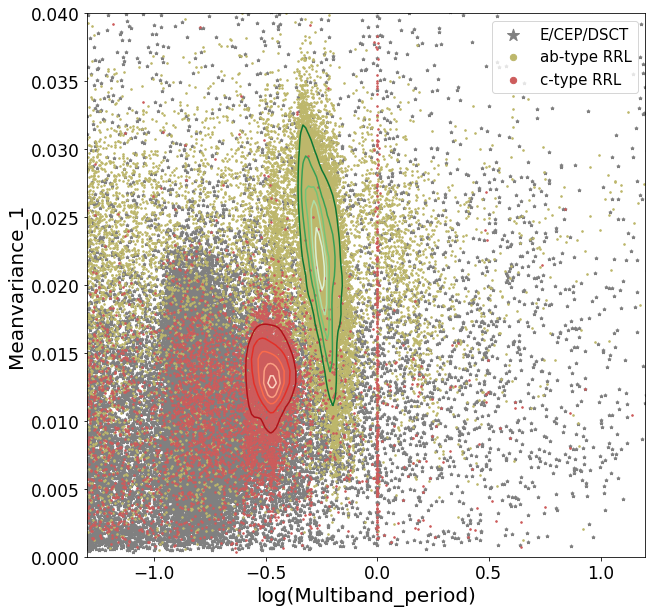

In [8]:
#magnitude distributions for labeled set and predictions in the unlabeled set
feature_x = 'log(Multiband_period)'
feature_y = 'Meanvariance_1'
logscale = False

df_train_plot = df_train.join(df_labels[['class_source']],how='left')
df_train_plot['log(Multiband_period)']=np.log10(df_train_plot['Multiband_period'])

df_train_plot = df_train_plot.loc[df_train_plot[feature_y]>0] 
#df_train_plot = df_train_plot.loc[(df_train_plot[feature_x]>0.01) & (df_train_plot[feature_x]<30)] 

#print(df_train_plot)

fig, ax = plt.subplots(figsize=(10, 10))

plt.scatter(df_train_plot[feature_x][df_train_plot['class_original']=="E"].values,df_train_plot[feature_y][df_train_plot['class_original']=="E"].values,c='grey',s=10,marker='*',label="E/CEP/DSCT")#,alpha=0.3)
plt.scatter(df_train_plot[feature_x][df_train_plot['class_original']=="DSCT"].values,df_train_plot[feature_y][df_train_plot['class_original']=="DSCT"].values,c='grey',s=10,marker='*')#,alpha=0.3)
plt.scatter(df_train_plot[feature_x][df_train_plot['class_original']=="CEP"].values,df_train_plot[feature_y][df_train_plot['class_original']=="CEP"].values,c='grey',s=10,marker='*')#,alpha=0.3)
plt.scatter(df_train_plot[feature_x][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))].values,df_train_plot[feature_y][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))].values,c='darkkhaki',s=10,marker='.',label="ab-type RRL")#,alpha=0.3)
plt.scatter(df_train_plot[feature_x][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))].values,df_train_plot[feature_y][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))].values,c='indianred',s=10,marker='.',label="c-type RRL")#,alpha=0.3)



#ax = sns.kdeplot(df_train_plot[feature_x][df_train_plot['class_original']=="E"].values,df_train_plot[feature_y][df_train_plot['class_original']=="E"].values, n_levels=5, cmap="Greens_r", shade=False)
#ax = sns.kdeplot(df_train_plot[feature_x][df_train_plot['class_original']=="DSCT"].values,df_train_plot[feature_y][df_train_plot['class_original']=="DSCT"].values, n_levels=5, cmap="Blues_r", shade=False)
ax = sns.kdeplot(df_train_plot[feature_x][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))].values,df_train_plot[feature_y][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))].values, n_levels=5,clip=(-1,0.2), linewidth=6,cmap="Greens_r", shade=False)
ax = sns.kdeplot(df_train_plot[feature_x][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))].values,df_train_plot[feature_y][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))].values, n_levels=5,clip=(-1,0.2), linewidth=6,cmap="Reds_r", shade=False)


#plt.text(1.,-0.53,'E',color='olive', fontsize=18)
#plt.text(1.,-0.53,'DSCT',color='lightsteelblue', fontsize=18)
#plt.text(1.,-0.53,'CEP',color='silver', fontsize=18)
#plt.text(1.,-0.4,'RRL ',color='lightcoral', fontsize=18)



plt.xlabel(r'log(Multiband_period)',fontsize=20)
plt.ylabel(r'Meanvariance_1',fontsize=20)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)

#plt.locator_params(axis='y', nbins=6)
#plt.locator_params(axis='x', nbins=6)
plt.xlim(-1.3,1.2)
plt.ylim(0,0.04)
#plt.xscale('log')

plt.legend(fontsize=15,markerscale=4.)



plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/Multiband_period_vs_meanvariance_g.png',bbox_inches='tight')

/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:434: UserWarning: The following kwargs were not used by contour: 'linewidth'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


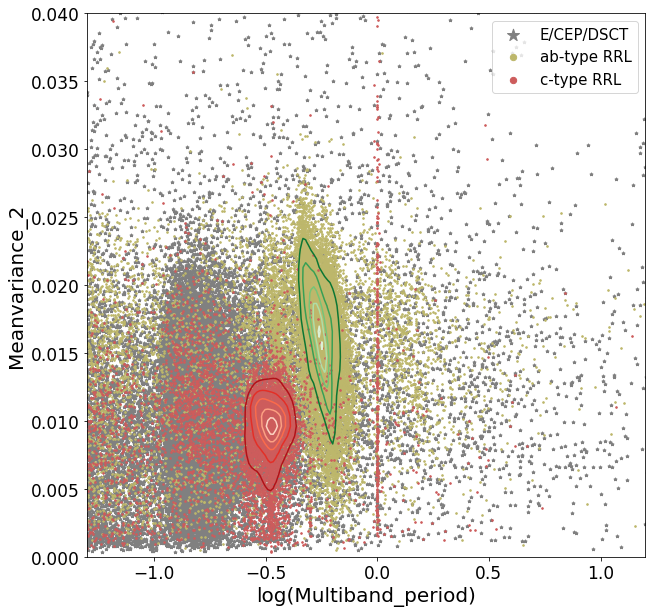

In [9]:
#magnitude distributions for labeled set and predictions in the unlabeled set
feature_x = 'log(Multiband_period)'
feature_y = 'Meanvariance_2'
logscale = False

df_train_plot = df_train.join(df_labels[['class_source']],how='left')
df_train_plot['log(Multiband_period)']=np.log10(df_train_plot['Multiband_period'])

df_train_plot = df_train_plot.loc[df_train_plot[feature_y]>0] 
#df_train_plot = df_train_plot.loc[(df_train_plot[feature_x]>0.01) & (df_train_plot[feature_x]<30)] 

#print(df_train_plot)

fig, ax = plt.subplots(figsize=(10, 10))

plt.scatter(df_train_plot[feature_x][df_train_plot['class_original']=="E"].values,df_train_plot[feature_y][df_train_plot['class_original']=="E"].values,c='grey',s=10,marker='*',label="E/CEP/DSCT")#,alpha=0.3)
plt.scatter(df_train_plot[feature_x][df_train_plot['class_original']=="DSCT"].values,df_train_plot[feature_y][df_train_plot['class_original']=="DSCT"].values,c='grey',s=10,marker='*')#,alpha=0.3)
plt.scatter(df_train_plot[feature_x][df_train_plot['class_original']=="CEP"].values,df_train_plot[feature_y][df_train_plot['class_original']=="CEP"].values,c='grey',s=10,marker='*')#,alpha=0.3)
plt.scatter(df_train_plot[feature_x][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))].values,df_train_plot[feature_y][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))].values,c='darkkhaki',s=10,marker='.',label="ab-type RRL")#,alpha=0.3)
plt.scatter(df_train_plot[feature_x][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))].values,df_train_plot[feature_y][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))].values,c='indianred',s=10,marker='.',label="c-type RRL")#,alpha=0.3)



#ax = sns.kdeplot(df_train_plot[feature_x][df_train_plot['class_original']=="E"].values,df_train_plot[feature_y][df_train_plot['class_original']=="E"].values, n_levels=5, cmap="Greens_r", shade=False)
#ax = sns.kdeplot(df_train_plot[feature_x][df_train_plot['class_original']=="DSCT"].values,df_train_plot[feature_y][df_train_plot['class_original']=="DSCT"].values, n_levels=5, cmap="Blues_r", shade=False)
ax = sns.kdeplot(df_train_plot[feature_x][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))].values,df_train_plot[feature_y][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))].values, n_levels=5,clip=(-1,0.2), linewidth=6,cmap="Greens_r", shade=False)
ax = sns.kdeplot(df_train_plot[feature_x][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))].values,df_train_plot[feature_y][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))].values, n_levels=5,clip=(-1,0.2), linewidth=6,cmap="Reds_r", shade=False)


#plt.text(1.,-0.53,'E',color='olive', fontsize=18)
#plt.text(1.,-0.53,'DSCT',color='lightsteelblue', fontsize=18)
#plt.text(1.,-0.53,'CEP',color='silver', fontsize=18)
#plt.text(1.,-0.4,'RRL ',color='lightcoral', fontsize=18)



plt.xlabel(r'log(Multiband_period)',fontsize=20)
plt.ylabel(r'Meanvariance_2',fontsize=20)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 17)

#plt.locator_params(axis='y', nbins=6)
#plt.locator_params(axis='x', nbins=6)
plt.xlim(-1.3,1.2)
plt.ylim(0,0.04)
#plt.xscale('log')

plt.legend(fontsize=15,markerscale=4.)



plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/Multiband_period_vs_meanvariance_r.png',bbox_inches='tight')

oid
ZTF19aapcxhy    False
ZTF18abtmwvo    False
ZTF18acvgdfy    False
ZTF19aapuscr    False
ZTF18aaodoxr    False
ZTF19aanxuxz    False
ZTF18acpoejm    False
ZTF19abanhub    False
ZTF19aaohxwd    False
ZTF18acidtzj    False
ZTF19aansigk    False
ZTF18acurjwf    False
ZTF18aacgfmr    False
ZTF19aaldoxu    False
ZTF18aaqdpre    False
ZTF18aawqdsi    False
ZTF18aaxzscm    False
ZTF19aaoznlm    False
ZTF19aauiwtc    False
ZTF18acvwlxd    False
ZTF18acrniue    False
ZTF19aadghed    False
ZTF18acnbgdv    False
ZTF19aaydtdo    False
ZTF19aapvkcg    False
ZTF18aautqnj    False
ZTF18aavljow    False
ZTF19aaqeksq    False
ZTF19abdkehs    False
ZTF19aasbqhs    False
                ...  
ZTF18abnndsb    False
ZTF18abmrxvs    False
ZTF17aabopvm    False
ZTF18acxdcsi    False
ZTF18aaxlpze    False
ZTF18aabfrjo    False
ZTF18abctdug    False
ZTF19aaedykz    False
ZTF18aczbnur    False
ZTF19aaoeaqp    False
ZTF18abnkabg    False
ZTF18abdkdai    False
ZTF18abvuhmv    False
ZTF18aayxpqn    False
ZTF18a

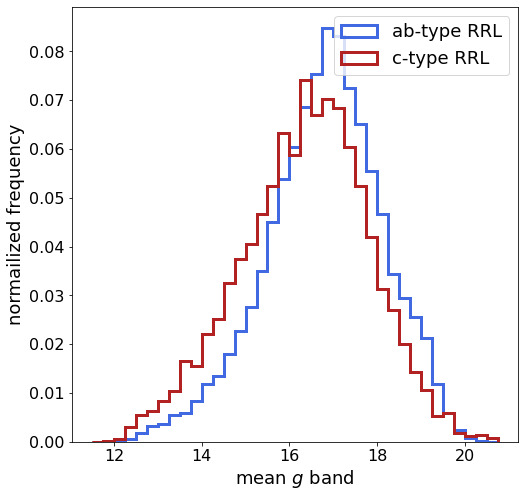

In [10]:

df_train_plot = df_train.join(df_labels[['class_source']],how='left')

df_train_plot = df_train_plot[df_train_plot['Mean_1']>-999]

fi = plt.figure(figsize=(8,8))

bins_hist = np.arange(11.5,21,0.25)

print((df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c')))
print((df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab')))



weights = np.ones_like(df_train_plot['Mean_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))])/float(len(df_train_plot['Mean_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))]))
binss,hist,p = plt.hist(df_train_plot['Mean_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='ab-type RRL', alpha=1.0)


weights = np.ones_like(df_train_plot['Mean_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))])/float(len(df_train_plot['Mean_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))]))
binss,hist,p = plt.hist(df_train_plot['Mean_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='c-type RRL', alpha=1.0)

plt.legend(fontsize=18)

plt.xlabel(r'mean $g$ band',fontsize=18)
plt.ylabel(r'normailized frequency',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/gband_dist_RRL.pdf',bbox_inches='tight')


oid
ZTF19aapcxhy    False
ZTF18abtmwvo    False
ZTF18acvgdfy    False
ZTF19aapuscr    False
ZTF18aaodoxr    False
ZTF19aanxuxz    False
ZTF18acpoejm    False
ZTF19abanhub    False
ZTF19aaohxwd    False
ZTF18acidtzj    False
ZTF19aansigk    False
ZTF18acurjwf    False
ZTF18aacgfmr    False
ZTF19aaldoxu    False
ZTF18aaqdpre    False
ZTF18aawqdsi    False
ZTF18aaxzscm    False
ZTF19aaoznlm    False
ZTF19aauiwtc    False
ZTF18acvwlxd    False
ZTF18acrniue    False
ZTF19aadghed    False
ZTF18acnbgdv    False
ZTF19aaydtdo    False
ZTF19aapvkcg    False
ZTF18aautqnj    False
ZTF18aavljow    False
ZTF19aaqeksq    False
ZTF19abdkehs    False
ZTF19aasbqhs    False
                ...  
ZTF18abnndsb    False
ZTF18abmrxvs    False
ZTF17aabopvm    False
ZTF18acxdcsi    False
ZTF18aaxlpze    False
ZTF18aabfrjo    False
ZTF18abctdug    False
ZTF19aaedykz    False
ZTF18aczbnur    False
ZTF19aaoeaqp    False
ZTF18abnkabg    False
ZTF18abdkdai    False
ZTF18abvuhmv    False
ZTF18aayxpqn    False
ZTF18a

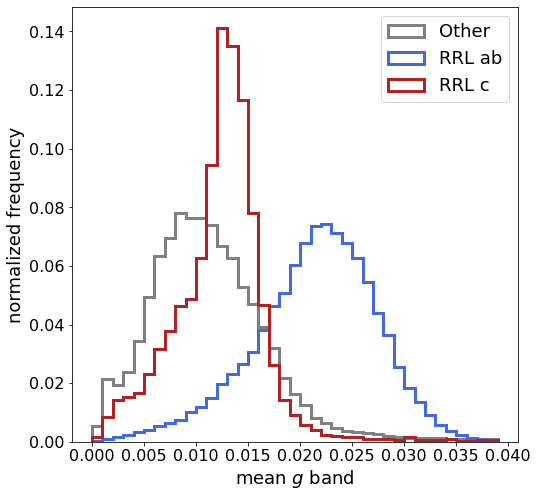

In [11]:
test_data_withclass = df_feat


df_train_plot = df_train.join(df_labels[['class_source']],how='left')

df_train_plot = df_train_plot[df_train_plot['Meanvariance_1']>-999]

fi = plt.figure(figsize=(8,8))

bins_hist = np.arange(0,0.04,0.001)

print((df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c')))
print((df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab')))


weights = np.ones_like(df_train_plot['Meanvariance_1'][(df_train_plot['class_original']=='CEP') | (df_train_plot['class_original']=='E') | (df_train_plot['class_original']=='DSCT')])/float(len(df_train_plot['Meanvariance_1'][(df_train_plot['class_original']=='CEP') | (df_train_plot['class_original']=='E') | (df_train_plot['class_original']=='DSCT')]))
binss,hist,p = plt.hist(df_train_plot['Meanvariance_1'][(df_train_plot['class_original']=='CEP') | (df_train_plot['class_original']=='E') | (df_train_plot['class_original']=='DSCT')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "grey", ec="grey",label='Other', alpha=1.0)



weights = np.ones_like(df_train_plot['Meanvariance_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))])/float(len(df_train_plot['Meanvariance_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))]))
binss,hist,p = plt.hist(df_train_plot['Meanvariance_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('AB')) | (df_train_plot['class_source'].str.contains('ab'))].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='RRL ab', alpha=1.0)


weights = np.ones_like(df_train_plot['Meanvariance_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))])/float(len(df_train_plot['Meanvariance_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))]))
binss,hist,p = plt.hist(df_train_plot['Meanvariance_1'][(df_train_plot['class_original']=='RRL') &(df_train_plot['class_source'].str.contains('C')) | (df_train_plot['class_source'].str.contains('c'))].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='RRL c', alpha=1.0)

plt.legend(fontsize=18)

plt.xlabel(r'mean $g$ band',fontsize=18)
plt.ylabel(r'normalized frequency',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/meanvariance_gband_dist_RRL.pdf',bbox_inches='tight')

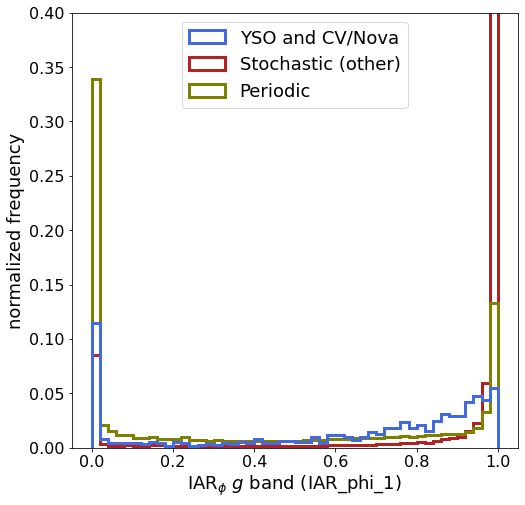

In [13]:
df_for_figures = df.copy()
df_for_figures = df_for_figures.join(labels)
df_for_figures.head()

bins_hist = np.arange(0,1.01,0.02)

fi = plt.figure(figsize=(8,8))

weights = np.ones_like(df_for_figures['IAR_phi_1'][(df_for_figures['class_original']=='YSO') | (df_for_figures['class_original']=='CV/Nova')].values)/float(len(df_for_figures['IAR_phi_1'][(df_for_figures['class_original']=='YSO') | (df_for_figures['class_original']=='CV/Nova')].values))
binss,hist,p = plt.hist(df_for_figures['IAR_phi_1'][(df_for_figures['class_original']=='YSO') | (df_for_figures['class_original']=='CV/Nova')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='YSO and CV/Nova', alpha=1.0)


weights = np.ones_like(df_for_figures['IAR_phi_1'][(df_for_figures['class_hierachical']=='Stochastic') & ((df_for_figures['class_original']!='YSO') | (df_for_figures['class_original']!='CV/Nova'))].values)/float(len(df_for_figures['IAR_phi_1'][(df_for_figures['class_hierachical']=='Stochastic') & ((df_for_figures['class_original']!='YSO') | (df_for_figures['class_original']!='CV/Nova'))].values))
binss,hist,p = plt.hist(df_for_figures['IAR_phi_1'][(df_for_figures['class_hierachical']=='Stochastic') & ((df_for_figures['class_original']!='YSO') | (df_for_figures['class_original']!='CV/Nova'))].values,weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='Stochastic (other)', alpha=1.0)

weights = np.ones_like(df_for_figures['IAR_phi_1'][(df_for_figures['class_hierachical']=='Periodic') & (df_for_figures['class_original']!='QSO')].values)/float(len(df_for_figures['IAR_phi_1'][df_for_figures['class_hierachical']=='Periodic'].values))  
binss,hist,p = plt.hist(df_for_figures['IAR_phi_1'][(df_for_figures['class_hierachical']=='Periodic') & (df_for_figures['class_original']!='QSO')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "blueviolet", ec="olive",label='Periodic', alpha=1.0)

weights = np.ones_like(df_for_figures['IAR_phi_1'][(df_for_figures['class_original']=='YSO') | (df_for_figures['class_original']=='CV/Nova')].values)/float(len(df_for_figures['IAR_phi_1'][(df_for_figures['class_original']=='YSO') | (df_for_figures['class_original']=='CV/Nova')].values))
binss,hist,p = plt.hist(df_for_figures['IAR_phi_1'][(df_for_figures['class_original']=='YSO') | (df_for_figures['class_original']=='CV/Nova')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue", alpha=1.0)



#weights = np.ones_like(df_for_figures['IAR_phi_1'][df_for_figures['class_original']=='CV/Nova'].values)/float(len(df_for_figures['IAR_phi_1'][df_for_figures['class_original']=='CV/Nova'].values))
#binss,hist,p = plt.hist(df_for_figures['IAR_phi_1'][df_for_figures['class_original']=='CV/Nova'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='CV/Nova', alpha=1.0)


plt.ylim(0,0.4)

    
plt.legend(loc='upper center',fontsize=18)
plt.xlabel(r'IAR$_{\phi}$ $g$ band (IAR_phi_1)',fontsize=18)
plt.ylabel(r'normalized frequency',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/IAR_phi_1_CV_YSO.pdf',bbox_inches='tight')

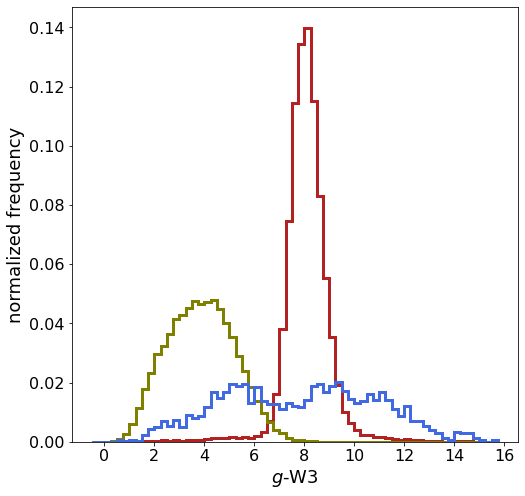

In [14]:
bins_hist = np.arange(-0.5,16,0.25)

fi = plt.figure(figsize=(8,8))
weights = np.ones_like(df_for_figures['g-W3'][(df_for_figures['class_hierachical']=='Stochastic') & ((df_for_figures['class_original']!='YSO') | (df_for_figures['class_original']!='CV/Nova'))].values)/float(len(df_for_figures['g-W3'][(df_for_figures['class_hierachical']=='Stochastic') & ((df_for_figures['class_original']!='YSO') | (df_for_figures['class_original']!='CV/Nova'))].values))
binss,hist,p = plt.hist(df_for_figures['g-W3'][(df_for_figures['class_hierachical']=='Stochastic') & ((df_for_figures['class_original']!='YSO') | (df_for_figures['class_original']!='CV/Nova'))].values,weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "firebrick", ec="firebrick",label='Stochastic (other)', alpha=1.0)

weights = np.ones_like(df_for_figures['g-W3'][(df_for_figures['class_hierachical']=='Periodic') & (df_for_figures['class_original']!='LPV')].values)/float(len(df_for_figures['g-W3'][df_for_figures['class_hierachical']=='Periodic'].values))  
binss,hist,p = plt.hist(df_for_figures['g-W3'][(df_for_figures['class_hierachical']=='Periodic') & (df_for_figures['class_original']!='LPV')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "blueviolet", ec="olive",label='Periodic (not LPV)', alpha=1.0)

weights = np.ones_like(df_for_figures['g-W3'][(df_for_figures['class_original']=='YSO') | (df_for_figures['class_original']=='CV/Nova')].values)/float(len(df_for_figures['g-W3'][(df_for_figures['class_original']=='YSO') | (df_for_figures['class_original']=='CV/Nova')].values))
binss,hist,p = plt.hist(df_for_figures['g-W3'][(df_for_figures['class_original']=='YSO') | (df_for_figures['class_original']=='CV/Nova')].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='YSO and CV/Nova', alpha=1.0)

#weights = np.ones_like(df_for_figures['IAR_phi_1'][df_for_figures['class_original']=='CV/Nova'].values)/float(len(df_for_figures['IAR_phi_1'][df_for_figures['class_original']=='CV/Nova'].values))
#binss,hist,p = plt.hist(df_for_figures['IAR_phi_1'][df_for_figures['class_original']=='CV/Nova'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=3, color = "royalblue", ec="royalblue",label='CV/Nova', alpha=1.0)


#plt.ylim(0,0.3)

    
#plt.legend(loc='upper left',fontsize=15)
plt.xlabel(r'$g$-W3',fontsize=18)
plt.ylabel(r'normalized frequency',fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=16)

plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/g_W3_1_CV_YSO.pdf',bbox_inches='tight')

[-0.4        -0.33793103 -0.27586207 -0.2137931  -0.15172414 -0.08965517
 -0.02758621  0.03448276  0.09655172  0.15862069  0.22068966  0.28275862
  0.34482759  0.40689655  0.46896552  0.53103448  0.59310345  0.65517241
  0.71724138  0.77931034  0.84137931  0.90344828  0.96551724  1.02758621
  1.08965517  1.15172414  1.2137931   1.27586207  1.33793103  1.4       ]
[0.0005     0.00062351 0.00077754 0.00096961 0.00120914 0.00150783
 0.0018803  0.00234479 0.00292402 0.00364633 0.00454708 0.00567034
 0.00707107 0.00881782 0.01099607 0.01371241 0.01709976 0.02132388
 0.02659148 0.03316032 0.04135186 0.05156693 0.06430541 0.08019065
 0.1       ]
[0.0005     0.00062351 0.00077754 0.00096961 0.00120914 0.00150783
 0.0018803  0.00234479 0.00292402 0.00364633 0.00454708 0.00567034
 0.00707107 0.00881782 0.01099607 0.01371241 0.01709976 0.02132388
 0.02659148 0.03316032 0.04135186 0.05156693 0.06430541 0.08019065
 0.1       ]


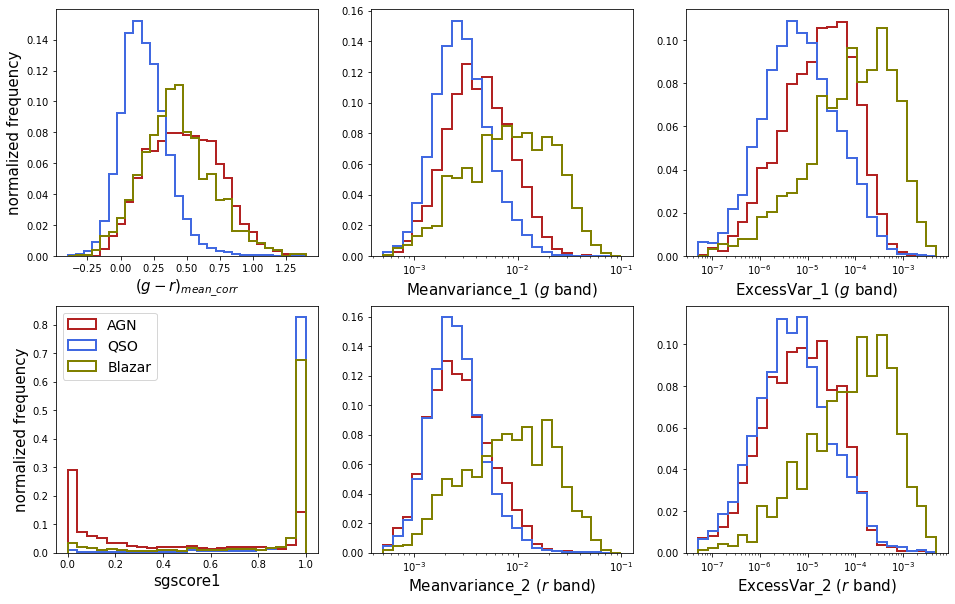

In [16]:
fig, ax = plt.subplots(nrows=2, ncols= 3, figsize = (16,10)) 


feature='g-r_mean_corr'
bins_hist = np.linspace(-0.4,1.4,30)#np.logspace(np.log10(5e-8),np.log10(1000),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
print(bins_hist)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values))
ax[0,0].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values,  weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values))
ax[0,0].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values,  weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values))
ax[0,0].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values,  weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
#ax[0,0].legend(loc='upper right',fontsize=17)
ax[0,0].set_xlabel(r'$(g-r)_{mean\_corr}$',fontsize=15)
ax[0,0].set_ylabel(r'normalized frequency',fontsize=15)

feature='Meanvariance_1'
bins_hist = np.logspace(np.log10(5e-4),np.log10(0.1),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
print(bins_hist)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values))
ax[0,1].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values))
ax[0,1].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values))
ax[0,1].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
#ax[0,1].legend(loc='upper right',fontsize=17)
ax[0,1].set_xlabel(r'Meanvariance_1 ($g$ band)',fontsize=15)
#ax[0,1].set_ylabel(r'normailized frequency',fontsize=15)
ax[0,1].set_xscale('log')

feature='Meanvariance_2'
bins_hist = np.logspace(np.log10(5e-4),np.log10(0.1),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
print(bins_hist)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values))
ax[1,1].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values))
ax[1,1].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values))
ax[1,1].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
#ax[1,1].legend(loc='upper right',fontsize=17)
ax[1,1].set_xlabel(r'Meanvariance_2 ($r$ band)',fontsize=15)
#ax[1,1].set_ylabel(r'normailized frequency',fontsize=15)
ax[1,1].set_xscale('log')

feature='ExcessVar_1'
bins_hist = np.logspace(np.log10(5e-8),np.log10(0.005),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values))
ax[0,2].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values))
ax[0,2].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values))
ax[0,2].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
#ax[0,2].legend(loc='upper left',fontsize=17)
ax[0,2].set_xlabel(r'ExcessVar_1 ($g$ band)',fontsize=15)
#ax[0,2].set_ylabel(r'normailized frequency',fontsize=15)
ax[0,2].set_xscale('log')

feature='ExcessVar_2'
bins_hist = np.logspace(np.log10(5e-8),np.log10(0.005),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values))
ax[1,2].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values))
ax[1,2].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values))
ax[1,2].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
#ax[1,2].legend(loc='upper left',fontsize=17)
ax[1,2].set_xlabel(r'ExcessVar_2 ($r$ band)',fontsize=15)
#ax[1,2].set_ylabel(r'normailized frequency',fontsize=15)
ax[1,2].set_xscale('log')


feature='sgscore1'
bins_hist = np.linspace(0,1,25,endpoint=True)#np.logspace(np.log10(2e-4),np.log10(1500),25, base=10.0,endpoint=True)
df_for_figures_aux = df_for_figures[df_for_figures[feature]>=np.min(bins_hist)]
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values))
ax[1,0].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='AGN'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "firebrick", ec="firebrick",label='AGN', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values))
ax[1,0].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='QSO'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "royalblue", ec="royalblue",label='QSO', alpha=1.0)
weights = np.ones_like(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values)/float(len(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values))
ax[1,0].hist(df_for_figures_aux[feature][df_for_figures_aux['class_original']=='Blazar'].values, weights=weights, cumulative=False, stacked=False, density=False, histtype='step', bins=bins_hist, lw=2, color = "blueviolet", ec="olive",label='Blazar', alpha=1.0)
ax[1,0].legend(loc='upper left',fontsize=14)
ax[1,0].set_xlabel(r'sgscore1',fontsize=15)
ax[1,0].set_ylabel(r'normalized frequency',fontsize=15)



plt.savefig('../../paper_late_classifier/paper_plots_2nd_version/feat_agn_classes.pdf',bbox_inches='tight')



